Ciclo Crisis 52-55 ignorado (fuera de rango)
Ciclo Expansión 56-69 ignorado (fuera de rango)
Ciclo Recesión 70-81 ignorado (fuera de rango)
Ciclo Expansión 56-69 ignorado (fuera de rango)
Ciclo Recesión 70-81 ignorado (fuera de rango)
Ciclo Crisis 82-85 ignorado (fuera de rango)
Ciclo Crisis 82-85 ignorado (fuera de rango)


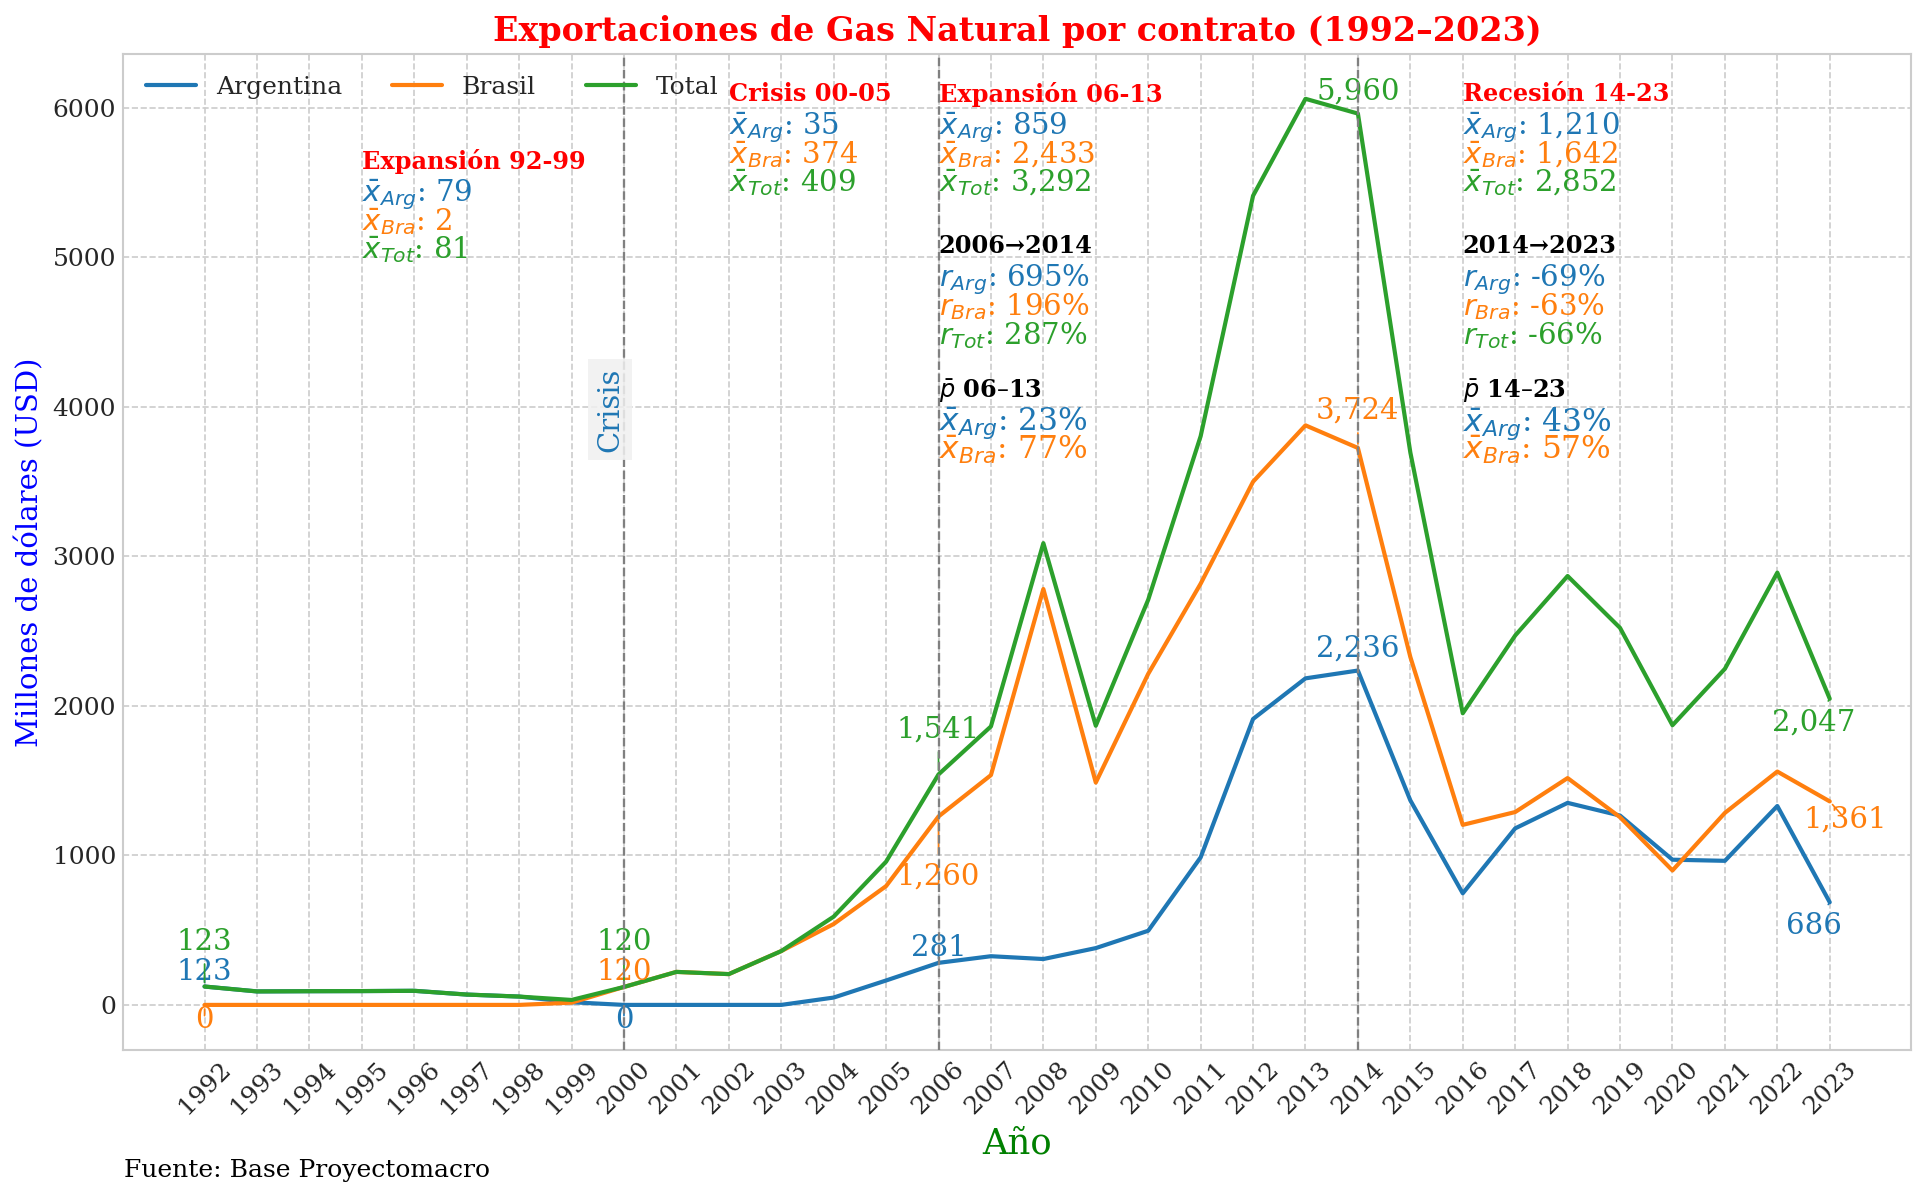

In [11]:
# ───────────────────────── 0. IMPORTS Y CONFIGURACIÓN GENERAL ─────────────────────────
import os, sys, sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# utilidades propias
sys.path.append(os.path.abspath('../'))
from graficos_utils import *
from config import *          # CYCLES, hitos_v, annot_years, periodos_tasas …

# Configuración general
output_dir = f"../../../../assets/tesis/serie_completa/exportaciones"
os.makedirs(output_dir, exist_ok=True)

set_style()                   # estilo único

# ───────────────────────────── 1. CARGA DE DATOS ─────────────────────────────
with sqlite3.connect("../../../../db/proyectomacro.db") as conn:
    df_raw = pd.read_sql(
        "SELECT año, destino, monto FROM exportacion_gas_natural_contratos",
        conn
    )

# Agrupamos y pivotamos
df = (df_raw.groupby(['año', 'destino'])['monto']
               .sum()
               .unstack(fill_value=0)
               .sort_index())
df['total'] = df.sum(axis=1)

# ──────────────── 2. COMPONENTES, COLORES Y ABREVIATURAS ────────────────
componentes = [
    ("Argentina", "Argentina"),
    ("Brasil",    "Brasil"),
    ("total",     "Total"),
]
cols_componentes = [c for c, _ in componentes]

cmap   = plt.get_cmap("tab10")
custom_colors = {col: cmap(i) for i, (col, _) in enumerate(componentes)}
abbr_componentes = {"Argentina": "Arg", "Brasil": "Bra", "total": "Tot"}

# ──────────────── 3. PREPARACIÓN ────────────────
cycles   = adjust_cycles(df, CYCLES)
annotate_years = adjust_annot_years(df, annot_years)      # (re)usa lista global
periodos = adjust_periods(df, periodos_tasas) # para tasas y growth
cycles_stats  = {name: df.loc[slc].mean().to_dict() for name, slc in cycles.items()}

# ──────────────── 4. OFFSETS ────────────────
hitos_offsets = {año: 0.67 for año in hitos_v}

annotation_offsets = {
    "Argentina": {1992:(0, 100), 2000:(0,-100), 2006:(0,100),
                  2008:(0,100), 2014:(0,150), 2023:(-0.3,-160)},
    "Brasil":    {1992:(0,-100), 2000:(0,100), 2006:(0,-400),
                  2008:(0,400), 2014:(0,250), 2023:(0.3,-120)},
    "total":     {1992:(0,300),  2000:(0,300), 2006:(0,300),
                  2008:(0,300), 2014:(0,150), 2023:(-0.3,-160)},
}

medias_offsets = {
    "Expansión 92-99": (1995, 0.9),
    "Crisis 00-05":    (2002, 0.97),
    "Expansión 06-13": (2006, 0.97),
    "Recesión 14-23":  (2016, 0.97),
}

tasas_offsets = {
    "2006-2014": (2006, 0.81),
    "2014-2023": (2016, 0.81),
}

participation_offsets = {
    "2006-2013": (2006, 0.66),
    "2014-2023": (2016, 0.66),
}

# ───────────────────────────── 5. GRÁFICA ─────────────────────────────
fig, ax = init_base_plot(
    df=df,
    series=componentes,
    colors=custom_colors,
    title=f"Exportaciones de Gas Natural por contrato ({df.index[0]}–{df.index[-1]})",
    xlabel="Año",
    ylabel="Millones de dólares (USD)",
    source_text="Fuente: Base Proyectomacro",
)

# 5.1 Hitos verticales
add_hitos(ax, df.index, hitos_v, hitos_offsets)

# 5.2 Medias de ciclo
line_spacing = ax.get_ylim()[1] * 0.03
add_cycle_means_multi(ax, cycles_stats, medias_offsets, abbr_componentes, custom_colors, line_spacing)

# 5.3 Tasas de crecimiento
add_period_growth_annotations_multi(
    ax, df, periodos, cols_componentes, tasas_offsets, custom_colors, abbr_componentes,
    fmt="{vi}→{vf}: {tasa}%",
)

# 5.4 Anotaciones puntuales
add_year_value_annotations(
    ax, df, annotate_years, cols_componentes, annotation_offsets, custom_colors, arrow_lw=0.8
)

# 5.5 Cuadros de participación
participation_periods = [(2006,2013), (2014,2023)]
add_participation_cycle_boxes(
    ax, df, participation_periods, ["Argentina","Brasil"], "total",
    participation_offsets, abbr_map=abbr_componentes, colors={c: custom_colors[c] for c in ["Argentina","Brasil"]}
)

plt.savefig(os.path.join(output_dir, "gas_natural_por_contrato.png"), dpi=300)
plt.show()